In [1]:
import numpy as np
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'


In [4]:
img_width, img_height=224,224
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'
nb_train_samples=400
nb_validation_samples=100
batch_size=128

        
train_datagen = ImageDataGenerator(rescale= 1. / 255,
                                   rotation_range=90,
                                   shear_range = 0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
        

train_batches = train_datagen.flow_from_directory(
                train_data_dir,
                target_size=(img_width,img_height), 
                classes=['dogs','cats'], 
                batch_size=40)

test_batches = ImageDataGenerator().flow_from_directory(
               test_data_dir,
               target_size=(img_width,img_height),
               classes=['dogs','cats'], 
               batch_size=40,
shuffle=False)

valid_batches = train_datagen.flow_from_directory(
               validation_data_dir, 
               target_size=(img_width,img_height),
               classes=['dogs','cats'],
               batch_size=40)

Found 8000 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 1920 images belonging to 2 classes.


## Load the model

In [5]:
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [7]:
for layer in model.layers:
    layer.trainable = False

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

## Load Weights

In [8]:
model.load_weights('vgg16weights.hdf5')

In [9]:
model.compile(optimizer=Adam(lr=.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
epochs=1

In [10]:
h=model.fit_generator(train_batches,
                      steps_per_epoch=62,
                      epochs = epochs,
                      validation_data=valid_batches,
                      validation_steps=15)

Epoch 1/1
62/62 [==============================] - 2303s 37s/step - loss: 0.3820 - accuracy: 0.8339 - val_loss: 0.4325 - val_accuracy: 0.8150


##  Visualize loss and accuracy

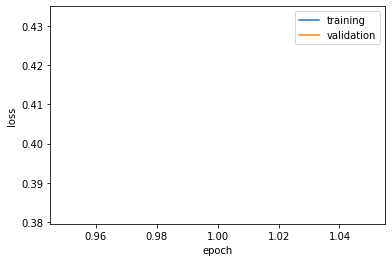

In [60]:
epoch_nums = range(1, epochs+1)
training_loss = h.history["loss"]
validation_loss = h.history["val_loss"]
plt.plot(epoch_nums , training_loss)
plt.plot(epoch_nums , validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training','validation'], loc='upper right')
plt.show()


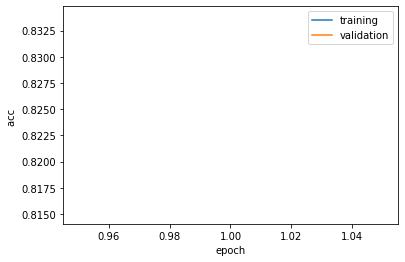

In [61]:
#Accuracy

epoch_nums = range(1, epochs+1)
training_acc = h.history["accuracy"]
validation_acc = h.history["val_accuracy"]
plt.plot(epoch_nums , training_acc)
plt.plot(epoch_nums , validation_acc)
plt.xlabel('epoch')
plt.ylabel('acc ')
plt.legend(['training','validation'], loc='upper right')
plt.show()

## saving weights

In [62]:
model.save_weights('vgg16weights.hdf5')

In [46]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.], dtype=float32)

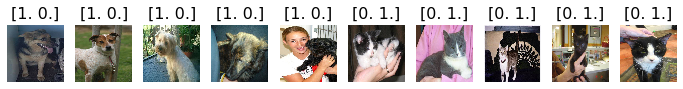

In [47]:
test_imgs,test_labels = next(test_batches)
plots(test_imgs,titles=test_labels)

test_labels = test_labels[:,0]
test_labels

# Predictions

In [58]:
import math

predictions = model.predict_generator(generator=test_batches, steps=1, verbose=0).round()
predictions

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

### Confusion Matrix,Recall,Precision 

              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89         5
         1.0       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10

Confusion Matrix
[[4 1]
 [0 5]]


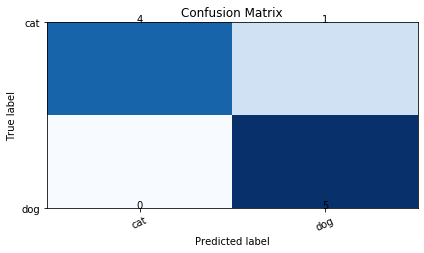

In [63]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions[:,0]))

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',):
    
    print('Confusion Matrix')
    print(cm)

    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=25)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black"
        )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(test_labels, predictions[:,0])
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')